<a href="https://colab.research.google.com/github/dkaratzas/DL2022-23/blob/main/Problems%204%20-%20MLP%20for%20Images/P4_MLP_for_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/dkaratzas/DL2022-23/blob/main/Problems%204%20-%20MLP%20for%20Images/P4_MLP_for_Images.ipynb)

# MLP for image classification

In this notebook we are going to learn how to use a Multi-Layer Perceptron (MLP) (Fully-Connected, Feed-Forward Network) for classifying images.

An MLP like the ones you used in the notebook of last week can be used with any kind of input data if we can represent it as a vector of real numbers. The shape of the input vector determines the size of the first layer in the model.

In the case of images (2D arrays of pixel values) we can get fixed-length vectors by: (1) using always images of the same size, and (2) flatenning the images into a 1D array. The flatten operation collapses an array into one dimension. For example, if we have a grayscale image of $28\times28$ pixels, its flattened version is a 1d array of $784$ pixel values. Now we can fed these $784$ values into a MLP for classifiying the image.

### Import the necessary libraries

In [14]:
import torch #should be installed by default in any colab notebook
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

### Use GPU if available

In [15]:
# If this cell fails you need to change the runtime of your colab notebook to GPU
# Go to Runtime -> Change Runtime Type and select GPU
assert torch.cuda.is_available(), "GPU is not enabled"

# use gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## The Fashion-MNIST dataset

[**Fashion-MNIST**](https://pytorch.org/vision/0.8/datasets.html#fashion-mnist) is a dataset consisting of a training set of $60,000$ examples and a test set of $10,000$ examples. Each example is a $28\times28$ grayscale image, associated with a label from $10$ classes. It was proposed as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.

Each training and test example is assigned to one of the following labels: 0 T-shirt/top, 1 Trouser, 2 Pullover, 3 Dress, 4 Coat, 5 Sandal, 6 Shirt, 7 Sneaker, 8 Bag, 9 Ankle boot.

The Fashion-MNIST dataset is available in [torchvision](https://pytorch.org/vision/stable/index.html) and can be loaded with the following code:

In [16]:
train_set = datasets.FashionMNIST("data", train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
val_set = datasets.FashionMNIST("data", train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))

print(train_set.data.size(), val_set.data.size())
print(train_set.targets.size(), val_set.targets.size())

torch.Size([60000, 28, 28]) torch.Size([10000, 28, 28])
torch.Size([60000]) torch.Size([10000])


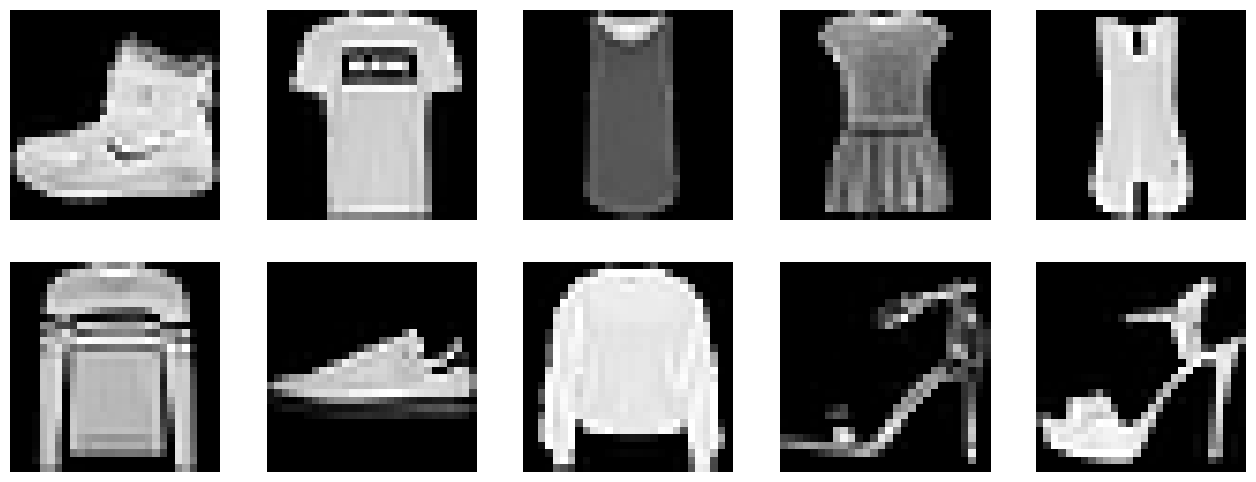

In [17]:
# show some images
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image = train_set.data[i,...]
    plt.imshow(image.squeeze().numpy(), cmap="gray")
    plt.axis('off');

<font color="blue">**Exercise 1**: When we loaded the Fashion-MNIST dataset we used the method `transforms.Compose`. Take a look at the documentation of [torchvision.transforms](https://pytorch.org/vision/0.8/transforms.html?highlight=transforms). Is there another transform that we can add to make our classification problem easier?</font>

---

Yes we can use the torchvision.transforms.Normalize(mean, std, inplace=False), what will be helpful for the data,


---

# Dataloaders

Now we introduce a **critical piece in any deep learning training process**: the dataloader. In Pytorch we can create a dataloader for a given dataset as follows:


In [18]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=1, shuffle=False, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=1, shuffle=False, num_workers=0)

<font color="blue">**Exercise 2**: Take a look at the documentation of [torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html?highlight=dataloader#torch.utils.data.DataLoader) and answer the following questions:</font>

<font color="blue">- What are the benefits of a dataloader?</font>

<font color="blue">- How can we make the dataloaders defined above better?</font>

---

Efficiency: Dataloader loads the data in batches, which can speed up the training process. This is especially important when working with large datasets that do not fit into memory.

Memory Management: Dataloader helps in managing the memory efficiently, as it loads only the necessary data into memory at any given time.

Randomization: Dataloader provides the ability to shuffle the data randomly, which helps to reduce the bias and variance of the model.

Parallelism: Dataloader can be used in parallel with the training process, allowing for faster and more efficient training.

Customization: Dataloader can be customized to meet the specific needs of the model and the data. This includes modifying the batch size, the order in which data is loaded, and applying transformations to the data.

Overall, using a dataloader can improve the performance, efficiency, and accuracy of a machine learning model.


- We could change the batch size to improve the dataloaders and also to shuffle them.

---

<font color="blue">**Exercise 3**: Now re-define the datasets and the dataloaders, and introduce normalisation (use the average of image means and stds of the training set for this), turn shuffling on, and use a batch size of 32.</font>

In [19]:
m = 0
s = 0
for img, label in train_set:
    m += img.mean()
    s += img.std()
    
m /= len(train_set)
s /= len(train_set)

print(m, s)

tensor(0.2860) tensor(0.3205)


In [20]:
transforms = transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=m, std=s, inplace=True)])
train_set = datasets.FashionMNIST("data", train=True, download=True, transform=transforms)
val_set = datasets.FashionMNIST("data", train=False, download=True, transform=transforms)

print(train_set.data.size(), val_set.data.size())
print(train_set.targets.size(), val_set.targets.size())

torch.Size([60000, 28, 28]) torch.Size([10000, 28, 28])
torch.Size([60000]) torch.Size([10000])


In [21]:
# Your Code Here

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=32, shuffle=True, num_workers=2)

<font color="blue">**Exercise 4**: Define the class for an MLP with two hidden layers using ReLU activations. The sizes of the input, output and hidden layers should be given during initialisation (using the `__init__()` class constructor parameters).</font>

In [22]:
# Your Code Here

class FCModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FCModel, self).__init__()        
        self.input_size = input_size
        self.network = nn.Sequential(
        #Your code here 
        nn.Linear(input_size,hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size,hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        x = x.view(-1, self.input_size) #SECURITY THING TO transform IT INTO A VECTOR 
        return self.network(x)

## Parameter Initialization

In PyTorch the default parameter initialization depends on the layer type. For example, for the Linear layer the default initialization is defined [here](https://github.com/pytorch/pytorch/blob/master/torch/nn/modules/linear.py#L87). Take a look and see if you recognize the initialization method.

You can find more initialization methods in the [`torch.nn.init`](https://pytorch.org/docs/stable/nn.init.html?highlight=init) module.

If necessary, you can change the default initialization of a layer as follows:

In [23]:
def initialize_parameters(model):
    for name, w in model.named_parameters():
        if "weight" in name:
            nn.init.ones_(w)
        
        if "bias" in name:
            nn.init.zeros_(w)   

## Create the model and initialize its parameters

In [24]:
learning_rate = 1e-3
lambda_l2 = 1e-5
torch.manual_seed(0) # seed for reproductibility

input_size  = 28*28   # images are 28x28 pixels
output_size = 10      # there are 10 classes

model = FCModel(input_size, 128, output_size)

# utility function to count number of parameters in a model
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.numel()
    return np

print(f"Number of parameters: {get_n_params(model)}")

# move model to gpu if available
model.to(device)

# nn package also has different loss functions.
# we use cross entropy loss for our classification task
criterion = torch.nn.CrossEntropyLoss() # https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss

#CROSS ENTROPY LOSS HAS THE SOFTMAX ADDED ON ITS FUNCTION THAT IS WHY WE DON'T PUT THE ACTIVATION FUNCTION IN THE LAST LAYER OF THE NETWORK

# we use the optim package to apply
# stochastic gradient descent for our parameter updates
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=lambda_l2) # built-in L2

# WARNING! What are we doing here?
initialize_parameters(model)

Number of parameters: 118282


## Define the train and validation methods

The following code should be easy to follow, but please note the following:

Here we use the function `torch.no_grad()` when we want to indicate to PyTorch that we do not want to calculate gradients. This saves a lot of computation and time, and we use it for example when we want to validate our model, when only forward calculations are needed. There are two ways to apply this function, and you can read about it here:
https://pytorch.org/docs/stable/generated/torch.no_grad.html

The way we use below is called a "decorator" function. It is a special super-power of python, and you can read more about it here:
https://realpython.com/primer-on-python-decorators/

Do not confuse `torch.no_grad()` with `model.eval()` and `model.train()`. The purpose of these two latter functions is to setup our model in different modes. This is very useful if you use layers that work in a different way during training and during evaluation, for example Dropout or Batch Normalisation. The model therefore needs to know how you are using it at any given time.

In [25]:
@torch.no_grad()  # prevent this function from computing gradients see https://pytorch.org/docs/stable/generated/torch.no_grad.html
def validate(criterion, model, loader):

    val_loss = 0
    correct = 0

    model.eval()

    for data, target in loader:

        data, target = data.to(device), target.to(device)

        data = data.view(-1, 28*28)
        output = model(data)
        loss = criterion(output, target)
        val_loss += loss.item()                                                              
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.view_as(pred)).sum().item()

    val_loss /= len(loader.dataset)
    accuracy = 100. * correct / len(loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(loader.dataset),
        accuracy))


    return val_loss


def train(epoch, criterion, model, optimizer, loader):
    
    total_loss = 0.0

    model.train()

    for batch_idx, (data, target) in enumerate(loader):
        
        optimizer.zero_grad()

        data, target = data.to(device), target.to(device)

        data = data.view(-1, 28*28)

        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        # print loss every N iterations
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(loader.dataset),
                100. * batch_idx / len(loader), loss.item()))


        total_loss += loss.item()  #.item() is very important here? Why?

    return total_loss / len(loader.dataset)

### The training loop

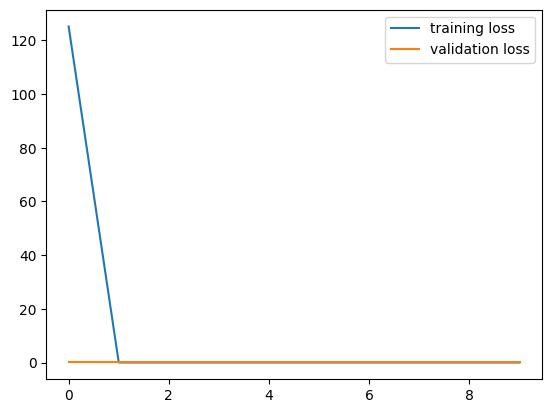

In [26]:
losses = {"train": [], "val": []}
for epoch in range(10):

    train_loss = train(epoch, criterion, model, optimizer, train_loader)
    val_loss = validate(criterion, model, val_loader)
    losses["train"].append(train_loss)
    losses["val"].append(val_loss)
    
    display.clear_output(wait=True)

    plt.plot(losses["train"], label="training loss")
    plt.plot(losses["val"], label="validation loss")

    plt.legend()
    plt.pause(0.000001)
    plt.show()   

# Visualising Results

It may also be useful to visualize some qualitative examples of classification 

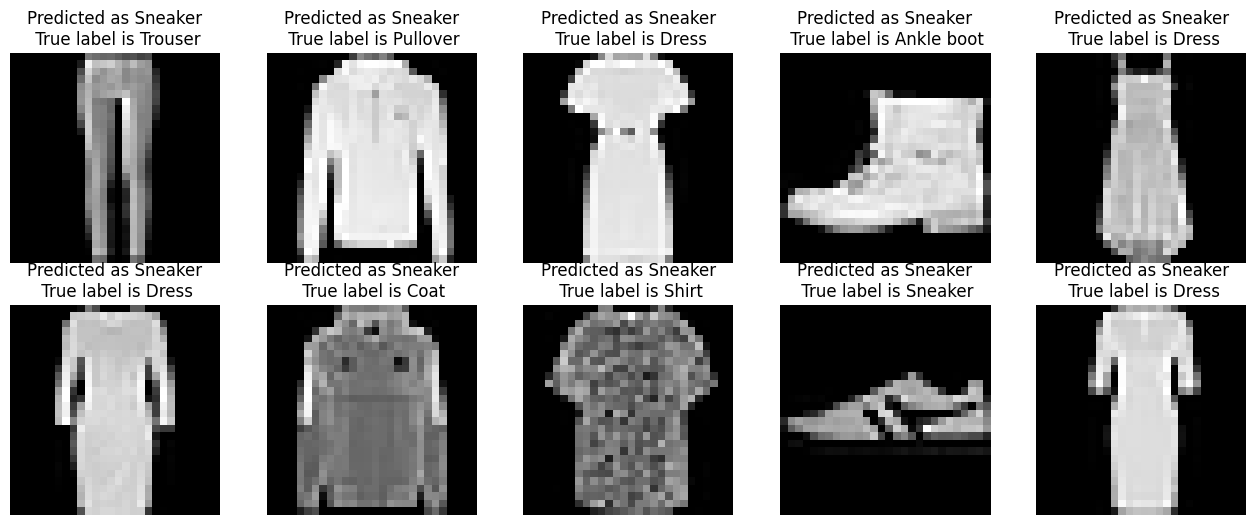

In [27]:
with torch.no_grad():

    data, target = next(iter(val_loader))
    data, target = data.to(device), target.to(device)

    data = data.view(-1, 28*28)
    output = model(data)
    predictions = np.argmax(output.cpu().numpy(), axis=1).tolist()
    true = target.cpu().numpy().tolist()
      
    plt.figure(figsize=(16, 6))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        image = data[i,...].cpu().numpy().reshape((28,28))
        plt.imshow(image, cmap="gray")
        plt.axis('off')
        plt.title('Predicted as {}\n True label is {}'.format(val_set.classes[predictions[i]], val_set.classes[true[i]], ))

# Homework

<font color="blue">**Exercise 5**: Change the initialization of the model parameters (this will help a great deal) and train your model on the Fashion-MNIST dataset.</font>

In [29]:
# Your Code Here
def initialize_parameters_relu(model):
    for name, w in model.named_parameters():
        if "weight" in name:
            nn.init.kaiming_uniform_(w, nonlinearity='relu')
        
        if "bias" in name:
            nn.init.zeros_(w) #WE USE KAMING BECAUSE WE ARE USING RELU as activation function

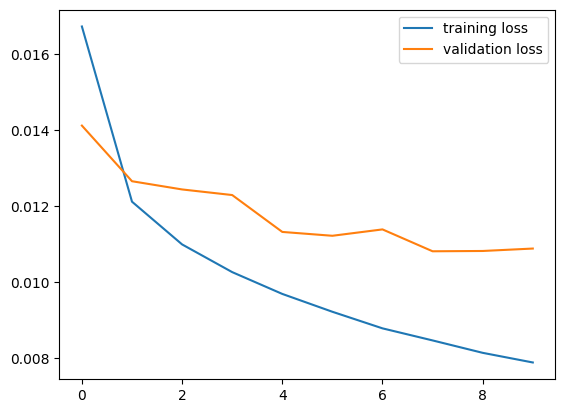

In [30]:
initialize_parameters_relu(model)
losses = {"train": [], "val": []}
for epoch in range(10):

    train_loss = train(epoch, criterion, model, optimizer, train_loader)
    val_loss = validate(criterion, model, val_loader)
    losses["train"].append(train_loss)
    losses["val"].append(val_loss)
    
    display.clear_output(wait=True)

    plt.plot(losses["train"], label="training loss")
    plt.plot(losses["val"], label="validation loss")

    plt.legend()
    plt.pause(0.000001)
    plt.show()   

In [31]:
# evaluate the trained model on the validation set
_ = validate(criterion, model, val_loader)


Test set: Average loss: 0.0109, Accuracy: 8728/10000 (87%)



<font color="blue">**Exercise 6**: Try to improve the Accuracy of your model on the validation set by adding more layers and/or more hidden units in you model. For example you can use a MLP with 2 hidden layers with 512 and 256 units respectively. You can also consider changing the batch size and learning rate if needed.</font>

In [32]:
# Your Code Here

class FCModel_complex(nn.Module):
    def __init__(self, input_size, output_size):
        super(FCModel_complex, self).__init__()        
        self.input_size = input_size
        self.network = nn.Sequential(
        #Your code here 
        nn.Linear(input_size, 512),
        nn.ReLU(),
        nn.Linear(512,256),
        nn.ReLU(),
        nn.Linear(256,100),
        nn.ReLU(),
        nn.Linear(100,output_size),
        )

    def forward(self, x):
        x = x.view(-1, self.input_size) #SECURITY THING TO transform IT INTO A VECTOR 
        return self.network(x)

In [33]:
train_loader_2 = torch.utils.data.DataLoader(train_set, batch_size=62, shuffle=True, num_workers=2)
val_loader_2 = torch.utils.data.DataLoader(val_set, batch_size=62, shuffle=True, num_workers=2)

model_complex = FCModel_complex(input_size, output_size)
# move model to gpu if available
model_complex.to(device)

initialize_parameters_relu(model_complex)
learning_rate_2 = 1e-3
optimizer_2 = torch.optim.SGD(model_complex.parameters(), lr=learning_rate_2, momentum=0.9, weight_decay=lambda_l2) # built-in L2

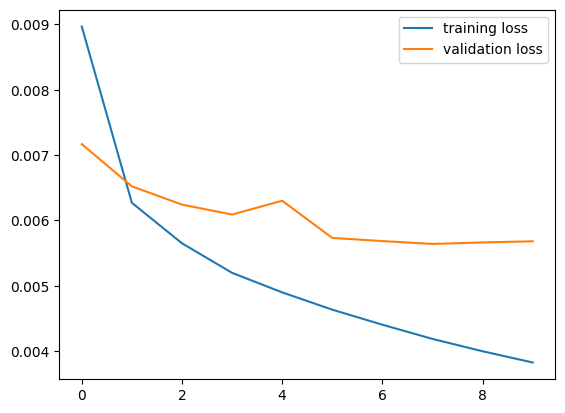

In [34]:
losses_SGD = {"train": [], "val": []}
for epoch in range(10):

    train_loss_SGD = train(epoch, criterion, model_complex, optimizer_2, train_loader_2)
    val_loss = validate(criterion, model_complex, val_loader_2)
    losses_SGD["train"].append(train_loss_SGD)
    losses_SGD["val"].append(val_loss)
    
    display.clear_output(wait=True)

    plt.plot(losses_SGD["train"], label="training loss")
    plt.plot(losses_SGD["val"], label="validation loss")

    plt.legend()
    plt.pause(0.000001)
    plt.show()  

In [35]:
# evaluate the trained model on the validation set
_ = validate(criterion, model_complex, val_loader_2)


Test set: Average loss: 0.0057, Accuracy: 8736/10000 (87%)



<font color="blue">**Exercise 7**: Try at least two different [optimizers](https://pytorch.org/docs/stable/optim.html#algorithms) (e.g. SGD with momentum, RMSProp, Adam, etc.) and plot **in a single matplotlib figure** the loss curves for training the model with them. We want them in a single figure to be able to easily compare the three learning curves.</font>

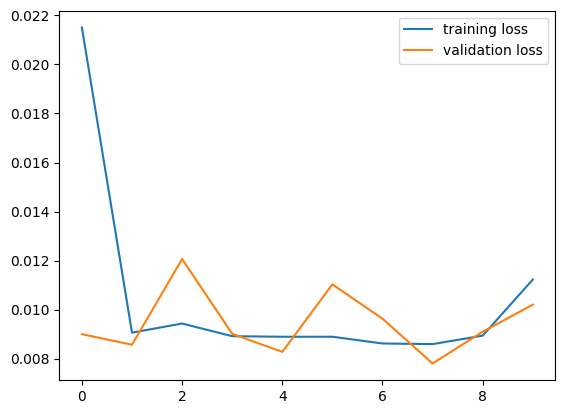

In [36]:
# Your code here
#RMSprop
optimizer_3 = torch.optim.RMSprop(model_complex.parameters(), lr=learning_rate_2, momentum=0.9, weight_decay=lambda_l2)
losses_RMS = {"train": [], "val": []}
for epoch in range(10):

    train_loss_RMS = train(epoch, criterion, model_complex, optimizer_3, train_loader_2)
    val_loss = validate(criterion, model_complex, val_loader_2)
    losses_RMS["train"].append(train_loss_RMS)
    losses_RMS["val"].append(val_loss)
    
    display.clear_output(wait=True)

    plt.plot(losses_RMS["train"], label="training loss")
    plt.plot(losses_RMS["val"], label="validation loss")

    plt.legend()
    plt.pause(0.000001)
    plt.show()  

In [37]:
# evaluate the trained model on the validation set
_ = validate(criterion, model_complex, val_loader_2)


Test set: Average loss: 0.0102, Accuracy: 7966/10000 (80%)



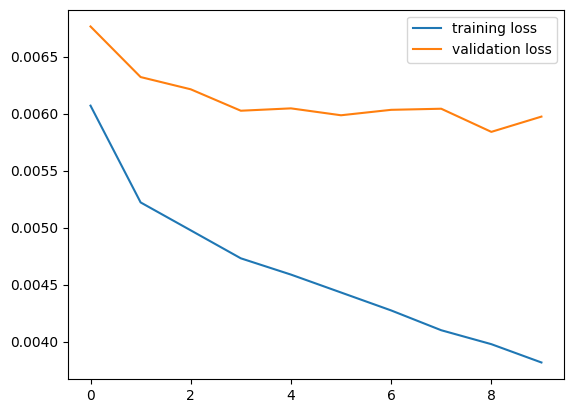

In [38]:
#ADAM
optimizer_4 = torch.optim.Adam(model_complex.parameters(), lr=learning_rate_2, weight_decay=lambda_l2)# built-in L2
losses_ADAM = {"train": [], "val": []}
for epoch in range(10):

    train_loss_ADAM = train(epoch, criterion, model_complex, optimizer_4, train_loader_2)
    val_loss = validate(criterion, model_complex, val_loader_2)
    losses_ADAM["train"].append(train_loss_ADAM)
    losses_ADAM["val"].append(val_loss)
    
    display.clear_output(wait=True)

    plt.plot(losses_ADAM["train"], label="training loss")
    plt.plot(losses_ADAM["val"], label="validation loss")

    plt.legend()
    plt.pause(0.000001)
    plt.show()  

In [39]:
# evaluate the trained model on the validation set
_ = validate(criterion, model_complex, val_loader_2)


Test set: Average loss: 0.0060, Accuracy: 8832/10000 (88%)



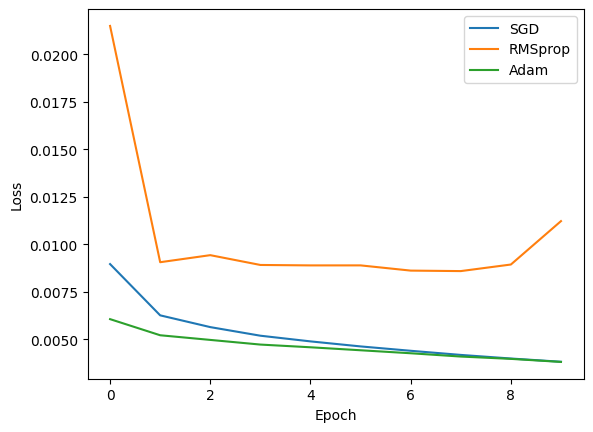

In [40]:
# Plot the loss curves for both optimizers
plt.plot(losses_SGD["train"], label='SGD')
plt.plot(losses_RMS["train"], label='RMSprop')
plt.plot(losses_ADAM["train"], label='Adam')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

<font color="blue">**Exercise 8**: Calculate the Accuracy for each individual class in the dataset and plot the [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html#sklearn.metrics.plot_confusion_matrix) of your trained models.</font>

Accuracy for each class: [86.4 97.2 82.1 86.6 79.8 96.4 67.7 95.5 97.  94.5]


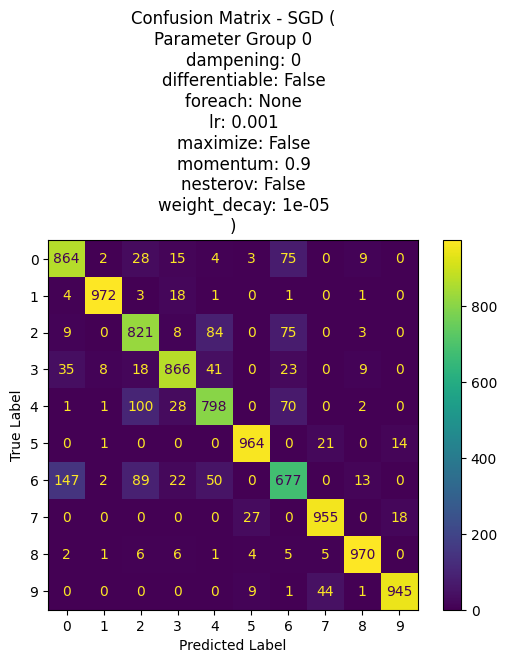

Accuracy for each class: [86.4 97.2 82.1 86.6 79.8 96.4 67.7 95.5 97.  94.5]


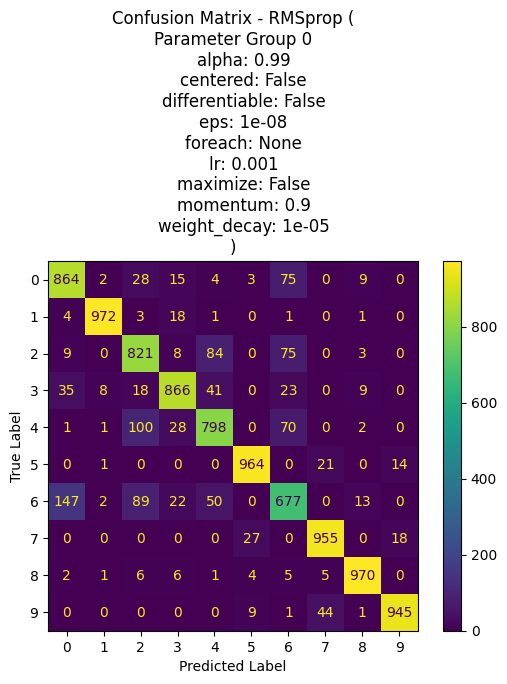

Accuracy for each class: [86.4 97.2 82.1 86.6 79.8 96.4 67.7 95.5 97.  94.5]


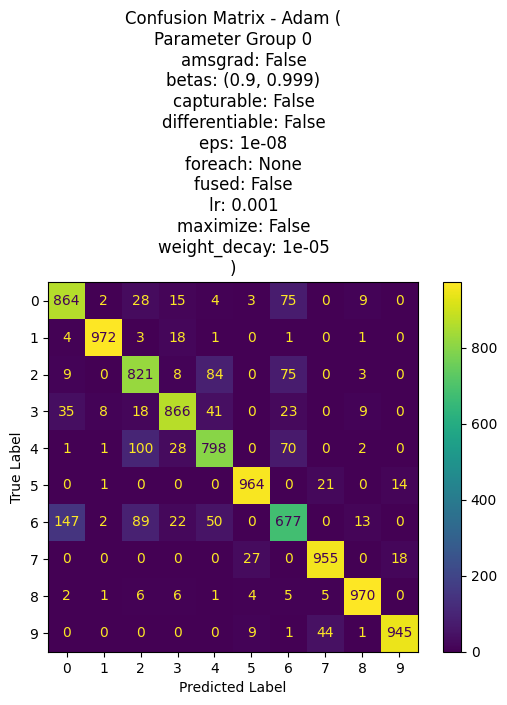

In [41]:
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import seaborn as sns

def test(net, optimizer):
    correct = np.zeros(10)
    total = np.zeros(10)
    y_true = []
    y_pred = []
    with torch.no_grad():
        for images, labels in val_loader_2:
            images, labels = images.to(device), labels.to(device)
            images = images.view(-1, 28*28)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1) #get the index of the max log-probability  
            c = (predicted == labels).squeeze()
            for i in range(len(labels)):
                label = labels[i]
                correct[label] += c[i].item()
                total[label] += 1
                y_true.append(label.item())
                y_pred.append(predicted[i].item())
    acc = 100 * correct / total
    print(f"Accuracy for each class: {acc}")
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {optimizer}")
    plt.show()

# Test the network with SGD optimizer
test(model_complex, optimizer_2)

# Test the network with RMSPROP optimizer
test(model_complex, optimizer_3)

# Test the network with ADAM optimizer
test(model_complex, optimizer_4)
